# Topic 1A 
**What time and space like interactions are most significant in multivariate systems?**

Setup
1.	Generate a 3D dataframe of times, variables, and their values, for a given timeseries of the first category of specifically discretised interactions.
2.	Write code to compute a list of cliques and their mutual information for a given 3D dataframe. The dataframe should contain the desired variables and their values over time. (for 3 variables, the output list should have length 14)
3.	Store the mutual informations as 2D matrix in a list, so a 3D dataframe.
4.	Plot <MI> vs dt, what result?

___________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Import libraries

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import infotopo
import networkx as nx
import matplotlib.patches as patches
from sklearn.utils import Bunch
from itertools import combinations

Import test data

In [2]:
df = pd.read_csv("C:\\Users\\cyril\\Documents\\Personal\\Github\\PhD_1\\timeseries_test.txt", sep='\t', header=0, usecols=lambda col: col != 'Time')  # choose between timeseries_test.txt and timeseries_test2.txt

Plot the timeseries for visualization

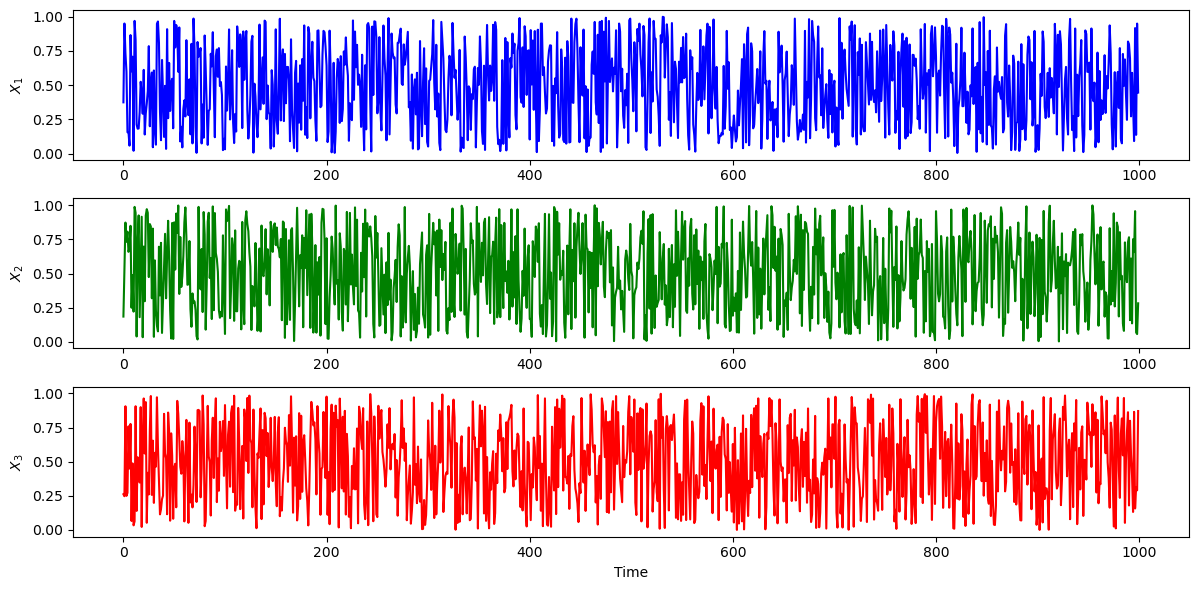

In [3]:
# Convert columns 1, 2, and 3 into lists of values
x_t = df.iloc[:, 0].tolist()
y_t = df.iloc[:, 1].tolist()
z_t = df.iloc[:, 2].tolist()
time = np.arange(0, len(x_t))

# Create the figure and subplots
plt.figure(figsize=(12, 6))  # Adjust the figure size to fit 3 plots

# First subplot for Series 1
plt.subplot(3, 1, 1)  # (3 rows, 1 column, first subplot)
plt.plot(time, x_t, label='Series 1', color='blue')
#plt.xlabel('Time')
plt.ylabel('$X_{1}$')
#plt.title('Series 1')
#plt.legend()

# Second subplot for Series 2
plt.subplot(3, 1, 2)  # (3 rows, 1 column, second subplot)
plt.plot(time, y_t, label='Series 2', color='green')
#plt.xlabel('Time')
plt.ylabel('$X_{2}$')
#plt.title('Series 2')
#plt.legend()

# Third subplot for Series 3
plt.subplot(3, 1, 3)  # (3 rows, 1 column, third subplot)
plt.plot(time, z_t, label='Series 3', color='red')
plt.xlabel('Time')
plt.ylabel('$X_{3}$')
#plt.title('Series 3')
#plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Convert the dataframe to a Bunch object

In [4]:
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

In [5]:
bunch = dataframe_to_bunch(df)

Use infotopo module to obtain the topological information metrics (entropy, mutual information and total correlation)

In [19]:
def obtain_infotopo_metrics(dataset):
    
    dimension_max = dataset.shape[1]
    dimension_tot = dataset.shape[1]
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = False
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(bunch.data) # Make sure the datatype is a Bunch object
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

Percent of tuples processed : 0


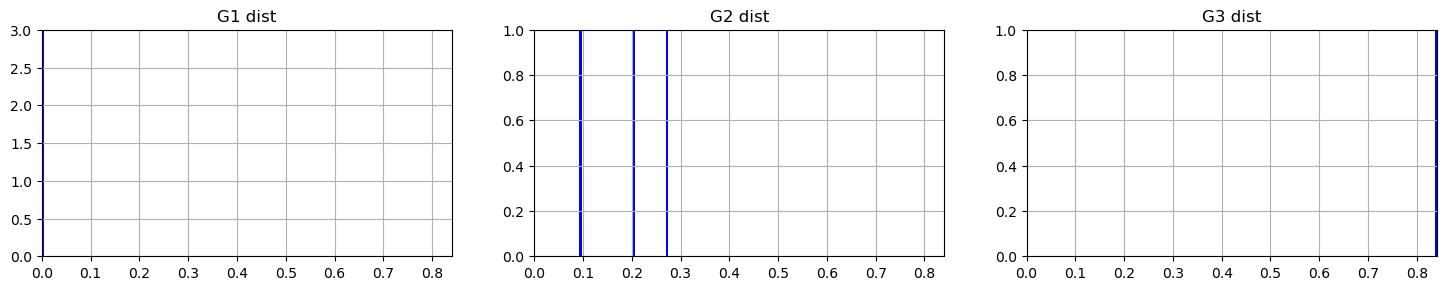

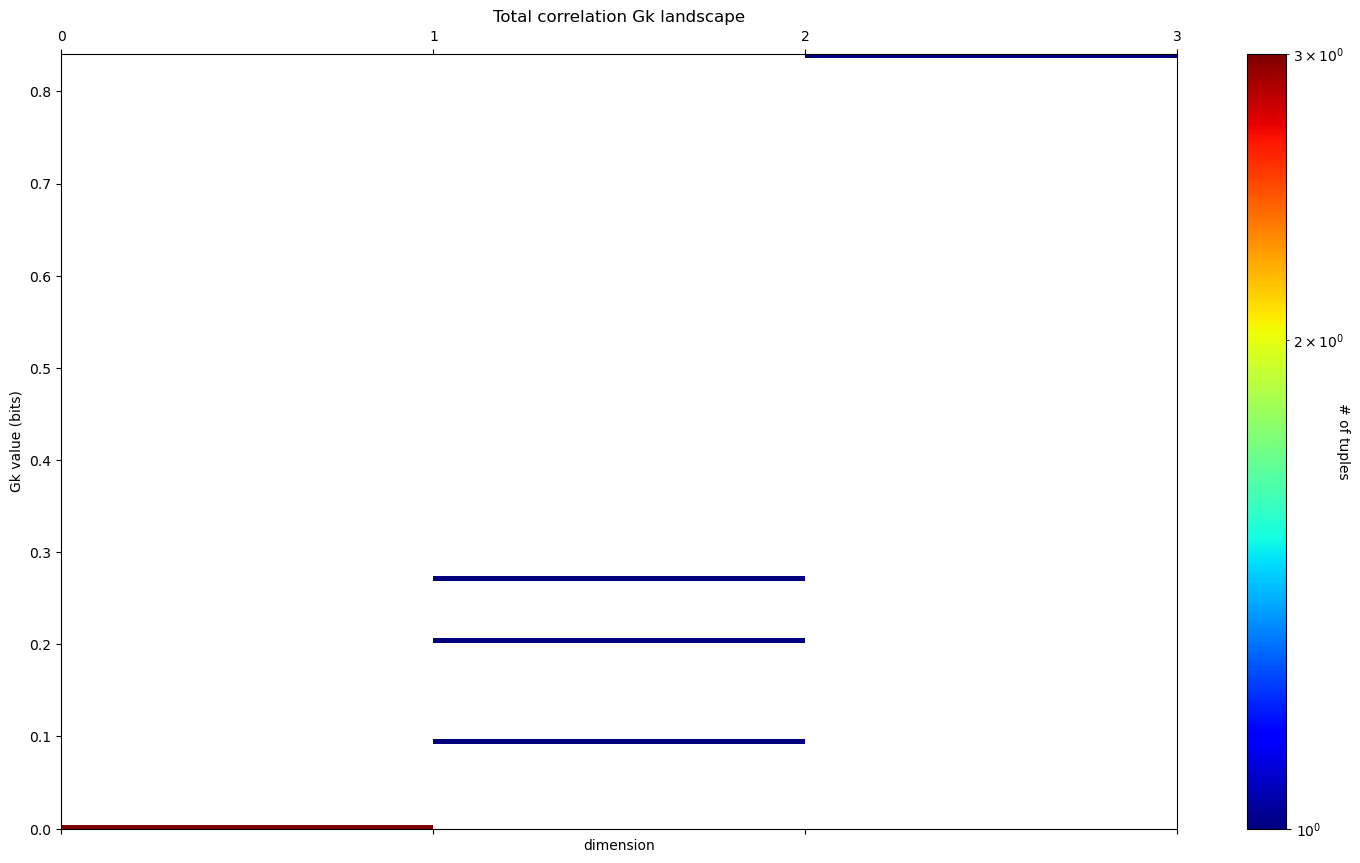

In [29]:
Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch.data)

In [31]:
Nentropie

{(3,): 2.793845335457739,
 (2,): 2.863812310176929,
 (1,): 2.6289928410132717,
 (2, 3): 5.454339104055581,
 (1, 3): 5.329638100807371,
 (1, 2): 5.220415562845133,
 (1, 2, 3): 7.445640671655438}

In [32]:
Ninfomut

{(3,): 2.793845335457739,
 (2,): 2.863812310176929,
 (1,): 2.6289928410132717,
 (2, 3): 0.2033185415790868,
 (1, 3): 0.0932000756636393,
 (1, 2): 0.2723895883450673,
 (1, 2, 3): -0.2721016094047082}

In [33]:
average_free_energy = sum(Nfree_energy.values())/len(Nfree_energy.values())
print(average_free_energy)

average_free_energy_component = sum(Ninfomut.values())/len(Ninfomut.values())
print(average_free_energy_component)

0.2014168600828993
1.2262081546901464


Convert the total correlations list to a similar dictionary structure as for Ninfomut and Nentropie

In [34]:
# Define the dictionary with keys
TC_dict = dict(Ninfomut)
values = Nfree_energy.values()

# Assign values to the keys in order
for key, value in zip(TC_dict.keys(), values):
    TC_dict[key] = value

In [35]:
TC_dict

{(3,): 0.0,
 (2,): 0.0,
 (1,): 0.0,
 (2, 3): 0.2033185415790868,
 (1, 3): 0.0932000756636393,
 (1, 2): 0.2723895883450673,
 (1, 2, 3): 0.8410098149925016}

Compute TSE complexity from the given total correlations list

In [37]:
def compute_subset_tc_expectation(TC_dict, gamma):
    """
    Computes the expected total correlation for subsets of size gamma.
    
    Parameters:
        TC_dict (dict): Dictionary where keys are tuples (subsets) and values are total correlations.
        gamma (int): Size of the subset.
    
    Returns:
        float: Expected total correlation for subsets of size gamma.
    """
    subsets = [subset for subset in TC_dict if len(subset) == gamma]
    subset_tcs = [TC_dict[subset] for subset in subsets]
    return np.mean(subset_tcs) if subset_tcs else 0  # Return 0 if no subsets of size gamma exist

def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum size of the subsets (full set)
    TSE = 0
    
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]  # Full set correlation scaled by gamma/N
        E_TC_gamma = compute_subset_tc_expectation(TC_dict, gamma)
        TSE += TC_full - E_TC_gamma
    
    return TSE

In [38]:
# Compute TSE complexity
tse_complexity = compute_tse_complexity(TC_dict)
print("TSE Complexity:", tse_complexity)

TSE Complexity: 0.651373746463237


Plot the resulting high order structure for a given/adjustable significance

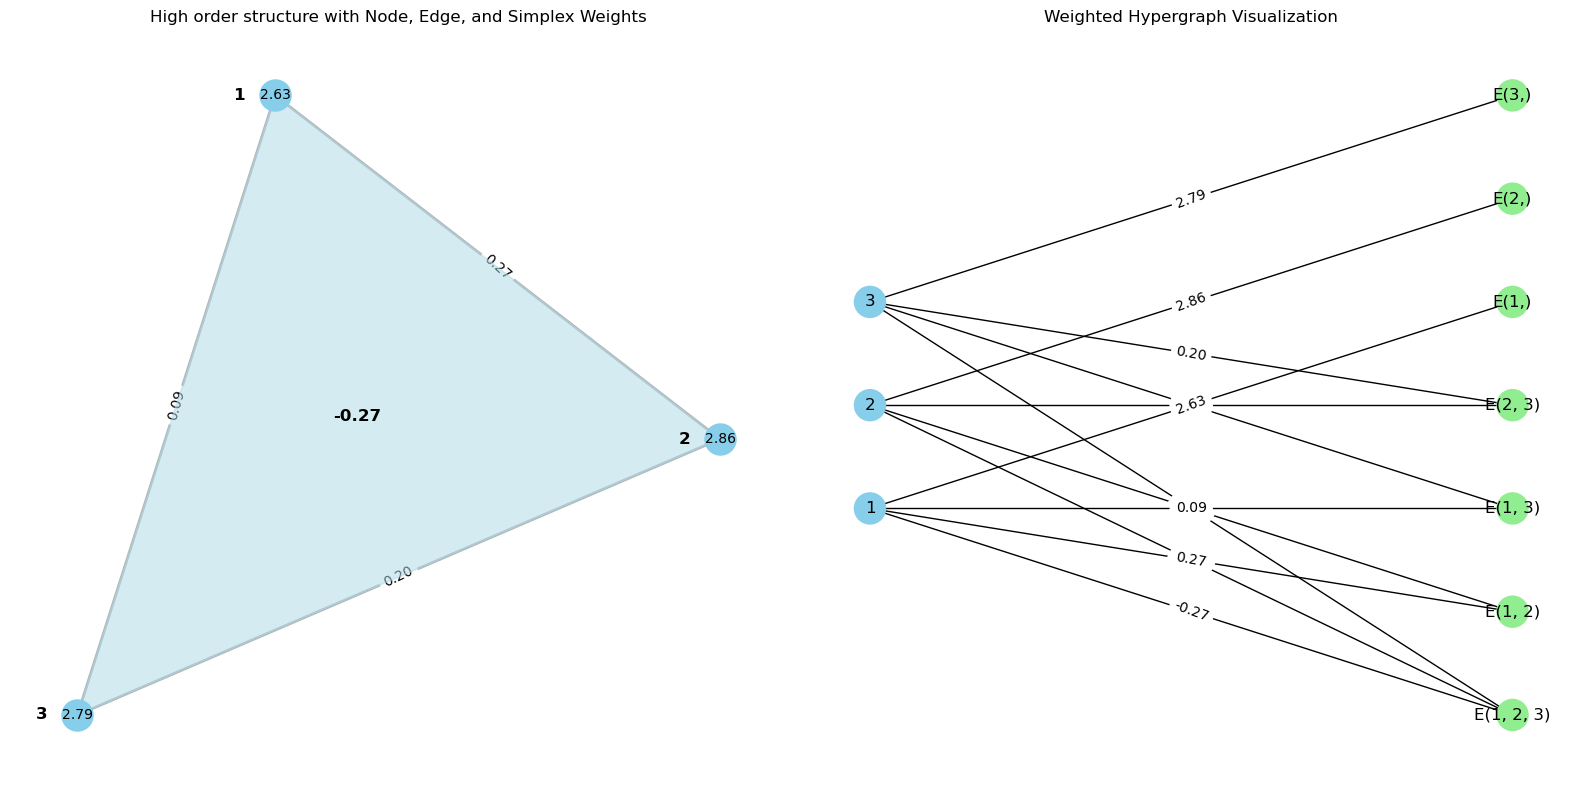

In [41]:
significance = 0

# Filter the interactions for a given significance and remove zero-weight hyperedges
hyperedges = {k: v for k, v in Ninfomut.items() if abs(v) > significance}

# Create a bipartite graph to represent the hypergraph
B = nx.Graph()

# Add nodes for each element in hyperedges
for edge, weight in hyperedges.items():
    edge_label = f"E{edge}"  # Label for the hyperedge
    B.add_node(edge_label, bipartite=1, weight=weight)  # Hyperedge node
    for node in edge:
        B.add_node(node, bipartite=0)  # Add regular graph node
        B.add_edge(edge_label, node, weight=weight)  # Connect hyperedge to its nodes

# Extract positions for bipartite graph layout
pos_B = nx.multipartite_layout(B, subset_key="bipartite")

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Adjust the size as needed

# Plot the simplicial complex in the first subplot (formerly second subplot)
# Given simplices with weights
simplices = hyperedges

# Create a graph to represent the simplicial complex
G = nx.Graph()

# Add nodes for each vertex in the simplices
nodes = set()
for simplex in simplices:
    nodes.update(simplex)
G.add_nodes_from(nodes)

# Add edges for 2-simplices (pairs of nodes) with weights
for simplex, weight in simplices.items():
    if len(simplex) == 2:  # Only add edges for 2-simplices
        G.add_edge(simplex[0], simplex[1], weight=weight)

# Add node weights (for simplices of length 1)
for simplex, weight in simplices.items():
    if len(simplex) == 1:  # Node weights come from 1-simplices
        G.nodes[simplex[0]]['weight'] = weight

# Create a layout for visualization
pos_G = nx.spring_layout(G, seed=42)

# Plot the simplicial complex in the first subplot
# Draw nodes
nx.draw_networkx_nodes(G, pos_G, node_size=500, node_color="skyblue", ax=ax[0])

# Draw edges
nx.draw_networkx_edges(G, pos_G, width=2, alpha=0.6, edge_color="gray", ax=ax[0])

# Draw labels for the edges (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos_G, edge_labels={e: f"{w:.2f}" for e, w in edge_labels.items()}, ax=ax[0])

# Display node weights as labels
node_weights = nx.get_node_attributes(G, 'weight')
nx.draw_networkx_labels(G, pos_G, labels={n: f"{w:.2f}" for n, w in node_weights.items()}, font_size=10, font_color="black", ax=ax[0])

# Set an adjustable offset for the node labels
offset = 0.07  # You can change this value to increase or decrease the distance of the label from the node

# Adjust the positions of the node number labels to ensure they are outside the nodes
adjusted_pos = {node: (x - offset, y) for node, (x, y) in pos_G.items()}

# Draw the node number labels with the adjusted positions
node_numbers = {n: str(n) for n in G.nodes()}
nx.draw_networkx_labels(G, adjusted_pos, labels=node_numbers, font_size=12, font_weight="bold", font_color="black", ax=ax[0])

# Visualize the weight of the 3-simplex (1, 2, 3)
simplex_3 = (1, 2, 3)
centroid = tuple(sum(pos_G[node][i] for node in simplex_3) / 3 for i in range(2))

# Get the weight of the (1, 2, 3) simplex
simplex_weight = simplices[simplex_3]

# Add the label for the 3-simplex weight at the centroid
ax[0].text(centroid[0], centroid[1], f'{simplex_weight:.2f}', fontsize=12, fontweight="bold", color="black", ha='center', va='center')

# Color the interior of the triangle if the weight of (1, 2, 3) is non-zero
if simplex_weight != 0:
    # Extract the positions of the nodes (1, 2, 3)
    node_positions = [pos_G[node] for node in simplex_3]
    
    # Create a Polygon to represent the triangle
    triangle = patches.Polygon(node_positions, closed=True, color='lightblue', alpha=0.5)
    
    # Add the triangle to the plot
    ax[0].add_patch(triangle)

# Set the title for the simplicial complex
ax[0].set_title("High order structure with Node, Edge, and Simplex Weights")

# Plot the hypergraph in the second subplot (formerly first subplot)
# Draw the nodes
node_colors = ["skyblue" if B.nodes[n]["bipartite"] == 0 else "lightgreen" for n in B.nodes()]
nx.draw_networkx_nodes(B, pos_B, node_color=node_colors, node_size=500, ax=ax[1])

# Draw the edges with weights
edge_labels = nx.get_edge_attributes(B, 'weight')
nx.draw_networkx_edges(B, pos_B, ax=ax[1])
nx.draw_networkx_labels(B, pos_B, ax=ax[1])

# Add edge weight labels
nx.draw_networkx_edge_labels(B, pos_B, edge_labels={e: f"{w:.2f}" for e, w in edge_labels.items()}, ax=ax[1])

# Set the title for the hypergraph
ax[1].set_title("Weighted Hypergraph Visualization")

# Turn off the axis for both plots
for a in ax:
    a.axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


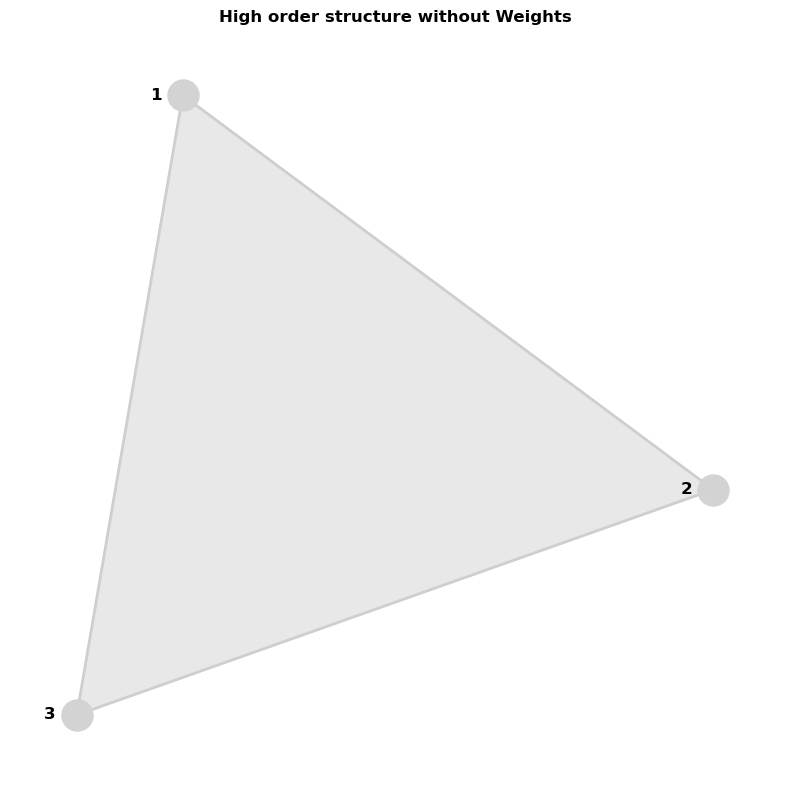

In [40]:
significance = 0

# Filter the interactions for a given significance and remove zero-weight hyperedges
hyperedges = {k: v for k, v in Ninfomut.items() if abs(v) > significance}

# Given simplices with weights
simplices = hyperedges

# Create a graph to represent the simplicial complex
G = nx.Graph()

# Add nodes for each vertex in the simplices
nodes = set()
for simplex in simplices:
    nodes.update(simplex)
G.add_nodes_from(nodes)

# Add edges for 2-simplices (pairs of nodes)
for simplex, weight in simplices.items():
    if len(simplex) == 2:  # Only add edges for 2-simplices
        G.add_edge(simplex[0], simplex[1])

# Create a layout for visualization
pos_G = nx.spring_layout(G, seed=42)

# Plot the simplicial complex
fig, ax = plt.subplots(figsize=(8, 8))  # Single plot

# Draw nodes
nx.draw_networkx_nodes(G, pos_G, node_size=500, node_color="lightgray", ax=ax)

# Draw edges
nx.draw_networkx_edges(G, pos_G, width=2, alpha=0.6, edge_color="darkgray", ax=ax)

# Fill triangles for 3-simplices in a shade of gray
for simplex in simplices:
    if len(simplex) == 3:  # Only consider 3-simplices
        # Extract the positions of the nodes
        node_positions = [pos_G[node] for node in simplex]
        # Create a Polygon to represent the triangle
        triangle = patches.Polygon(node_positions, closed=True, color='lightgray', alpha=0.5)
        # Add the triangle to the plot
        ax.add_patch(triangle)

# Set an adjustable offset for the node labels
offset = 0.07  # You can change this value to increase or decrease the distance of the label from the node

# Adjust the positions of the node number labels to ensure they are outside the nodes
adjusted_pos = {node: (x - offset, y) for node, (x, y) in pos_G.items()}

# Draw the node number labels with the adjusted positions
node_numbers = {n: str(n) for n in G.nodes()}
nx.draw_networkx_labels(G, adjusted_pos, labels=node_numbers, font_size=12, font_weight="bold", font_color="black", ax=ax)

# Set the title for the simplicial complex
ax.set_title("High order structure without Weights", fontweight="bold")

# Turn off the axis
ax.axis("off")

# Display the plot
plt.tight_layout()
plt.show()
